In [ ]:
# Importing libraries
import sys
import keras
import cv2
import skimage
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

In [ ]:
# Defining Image Quality Matric Functions
def psnr(target, ref):

    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])

    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))

    return scores

In [ ]:
# Preparing Images (degraded) by resizing
cwd = os.getcwd()  # Get the current working directory (cwd)


def prepare_images(path, factor):

    # loop through the files in the directory
    for file in os.listdir(path):
        try:
          # open the file
          img = cv2.imread(path + '/' + file)

          # find old and new image dimensions
          h, w, _ = img.shape
          new_height = int(h / factor)
          new_width = int(w / factor)

          # resize the image - down
          img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)

          # resize the image - up
          img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)

          # save the image
          print('Saving {}'.format(file))
          cv2.imwrite('images/{}'.format(file), img)
        except:
          print('ERROR for file-', file, '!')
          pass

prepare_images('source/', 2)

Saving Te-glTr_0003.jpg
Saving IIT-Kharagour.jpg
Saving 106024.png
Saving Te-piTr_0008.jpg
Saving patch_00015.png
Saving board.jpeg
Saving patch_00001.png
Saving butterfly.png
Saving iitpng.png


In [ ]:
# Testing Quality difference between source and image (degraded)
for file in os.listdir('images/'):
    try:
      # open target and reference images
      target = cv2.imread('images/{}'.format(file))
      ref = cv2.imread('source/{}'.format(file))

      # calculate score
      scores = compare_images(target, ref)

      # print all three scores with new line characters (\n)
      print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1]))
    except:
      pass

In [ ]:
# Defining SRCNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.optimizers import Adam


def model():

    # define model type
    SRCNN = Sequential()
    # SRCNN.add(Input(shape=(None, None, 3)))
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))

    # define optimizer
    adam = Adam(learning_rate=0.0003)

    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

    return SRCNN

In [ ]:
# Defining SRCNN Model
srcnn = model()
srcnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, None, None,     │        10,496 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 64) │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None, 1)  │         1,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,889 (335.50 KB)

 Trainable params: 85,889 (335.50 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Degraded Image: 
PSNR: 24.746475979490427
MSE: 653.9642651585295

Reconstructed Image: 
PSNR: 26.66362810974053
MSE: 420.57049790212125



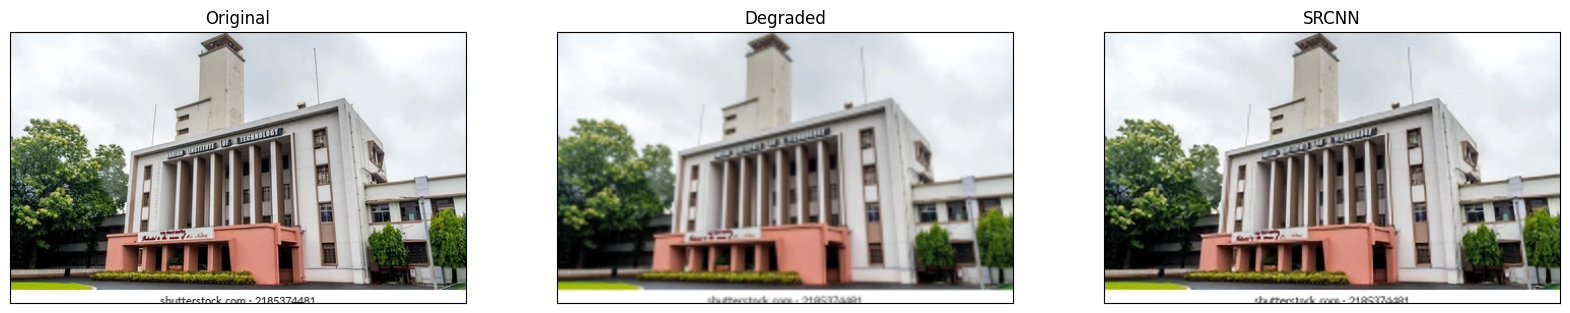

In [ ]:
# Image Processing Functions
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img
# define main prediction function

def predict(image_path):

    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')

    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))

    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)

    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)

    # create image slice and normalize
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255

    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)

    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)

    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)

    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)

    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))

    # return images and scores
    return ref, degraded, output, scores
ref, degraded, output, scores = predict('images/iitpng.png')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\n'.format(scores[0][0], scores[0][1]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\n'.format(scores[1][0], scores[1][1]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
SRCNN output saved: output/Te-glTr_0003.jpg.png


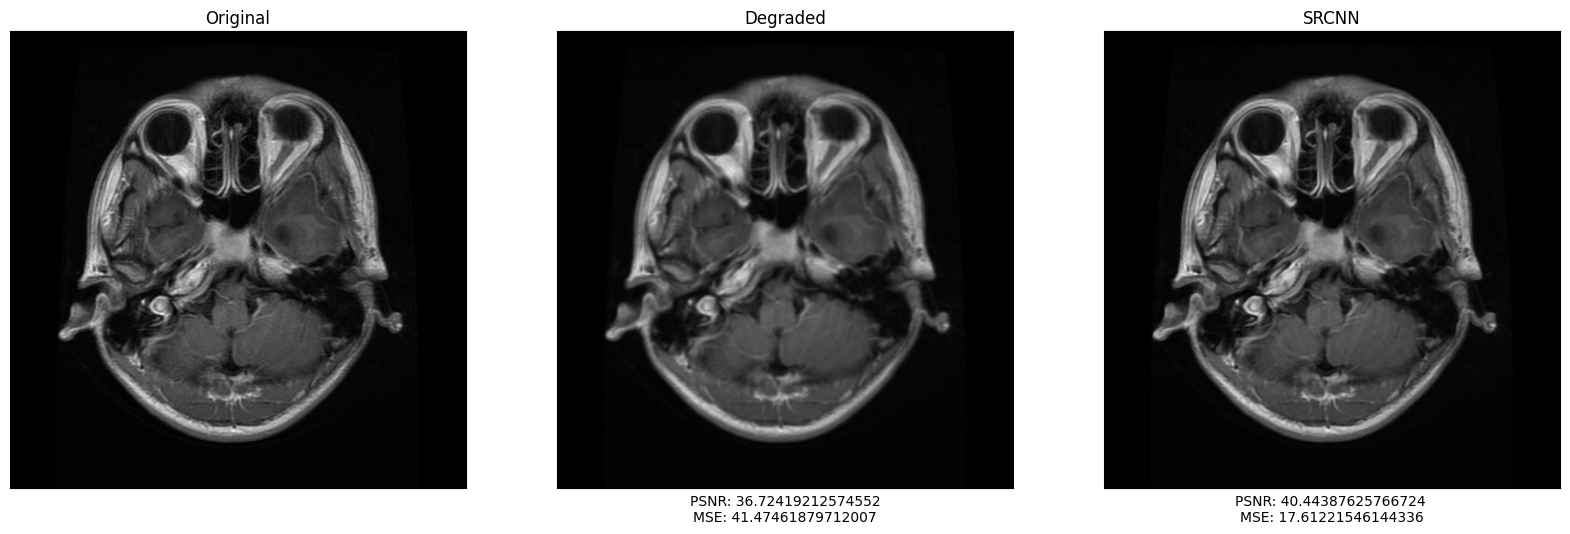

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
SRCNN output saved: output/IIT-Kharagour.jpg.png


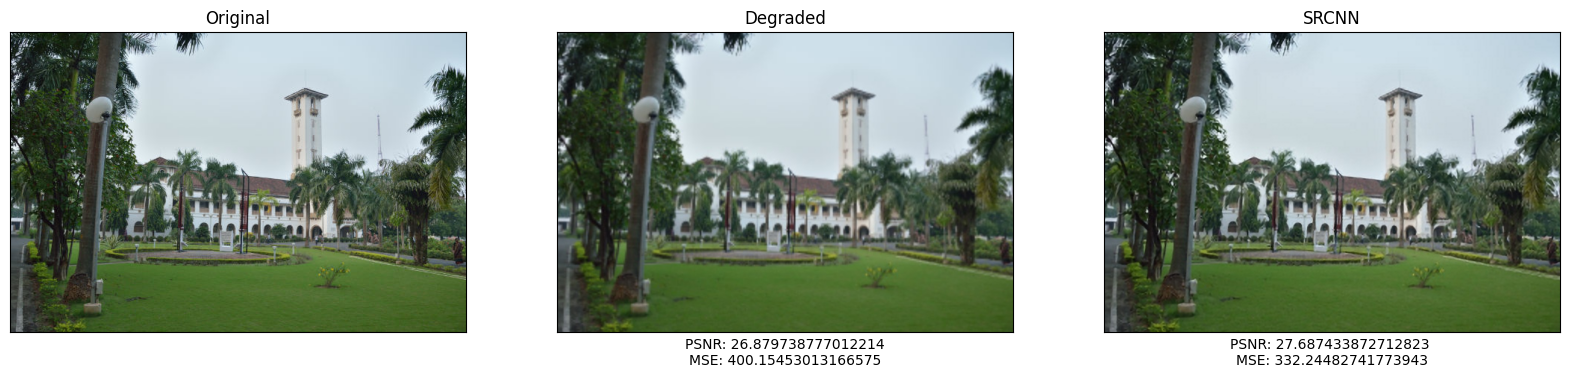

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
SRCNN output saved: output/106024.png.png


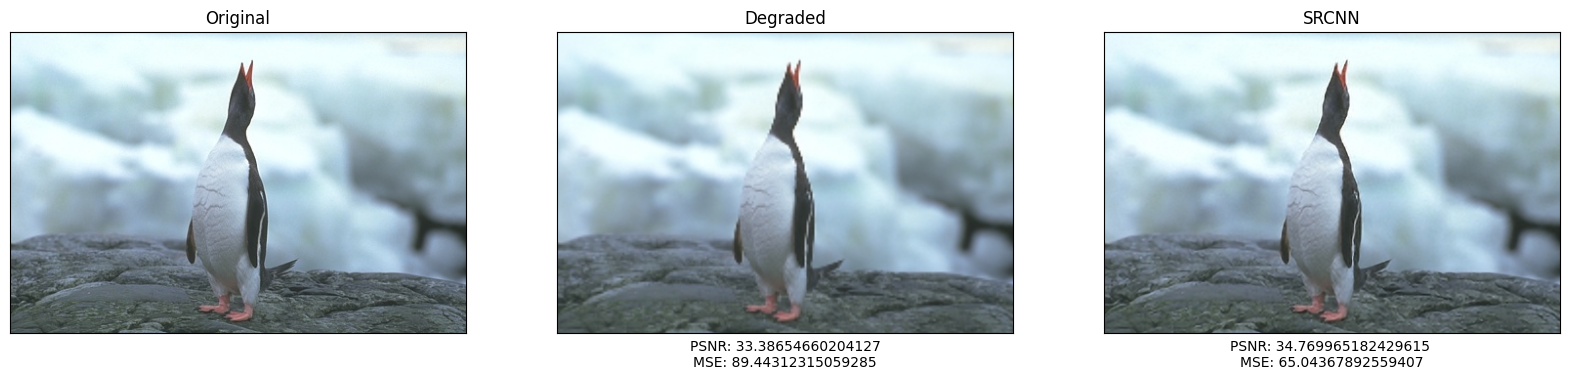

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
SRCNN output saved: output/Te-piTr_0008.jpg.png


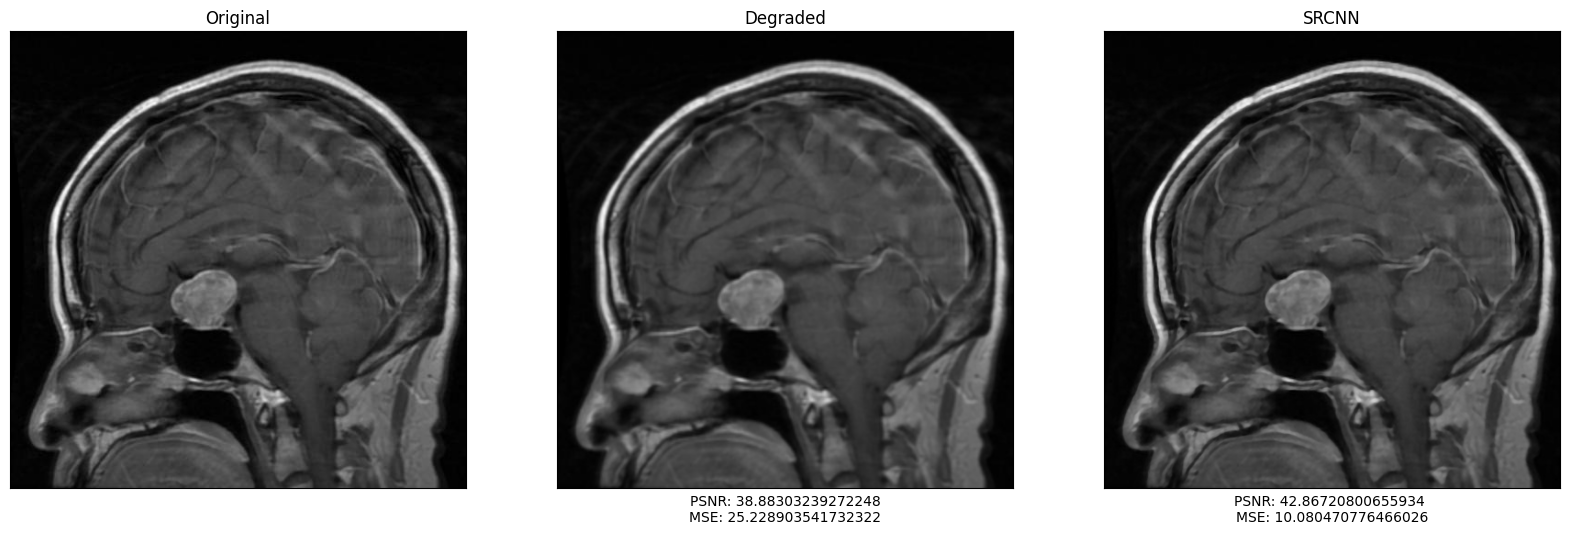

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
SRCNN output saved: output/patch_00015.png.png


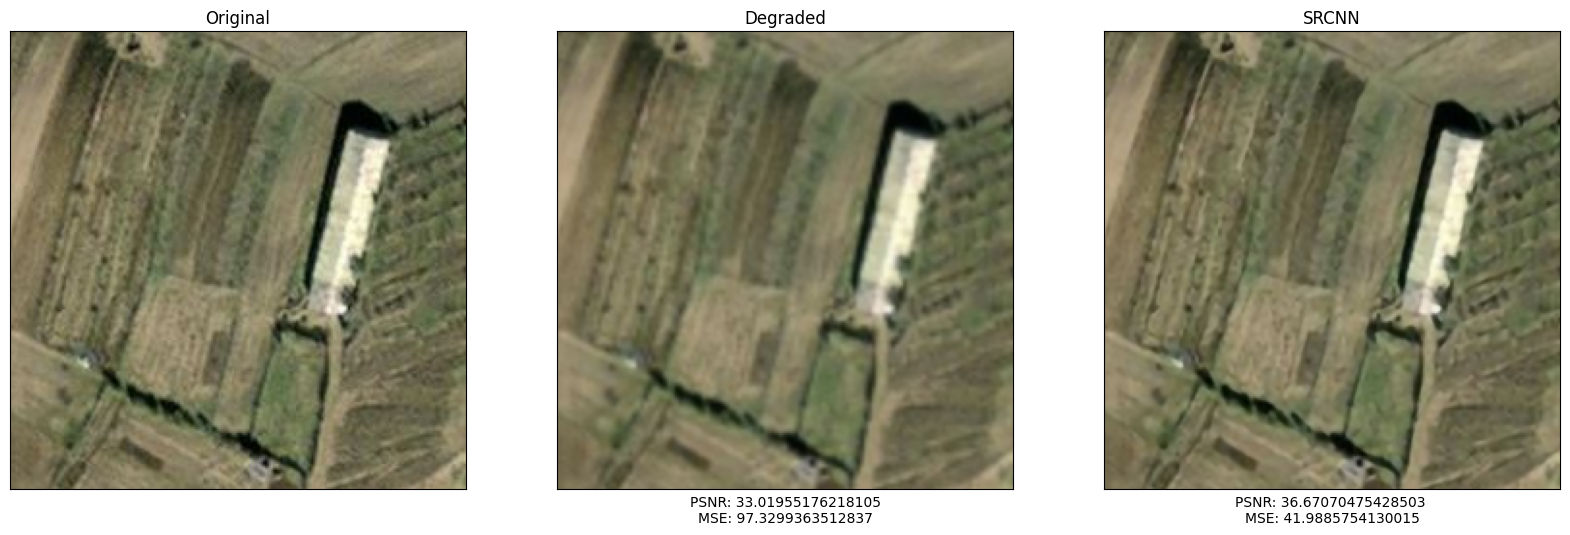

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
SRCNN output saved: output/board.jpeg.png


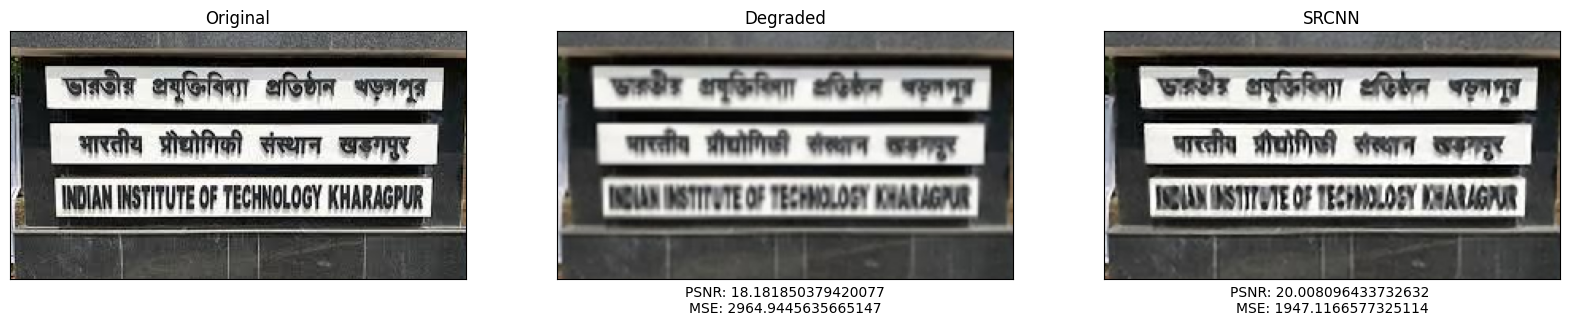

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
SRCNN output saved: output/patch_00001.png.png


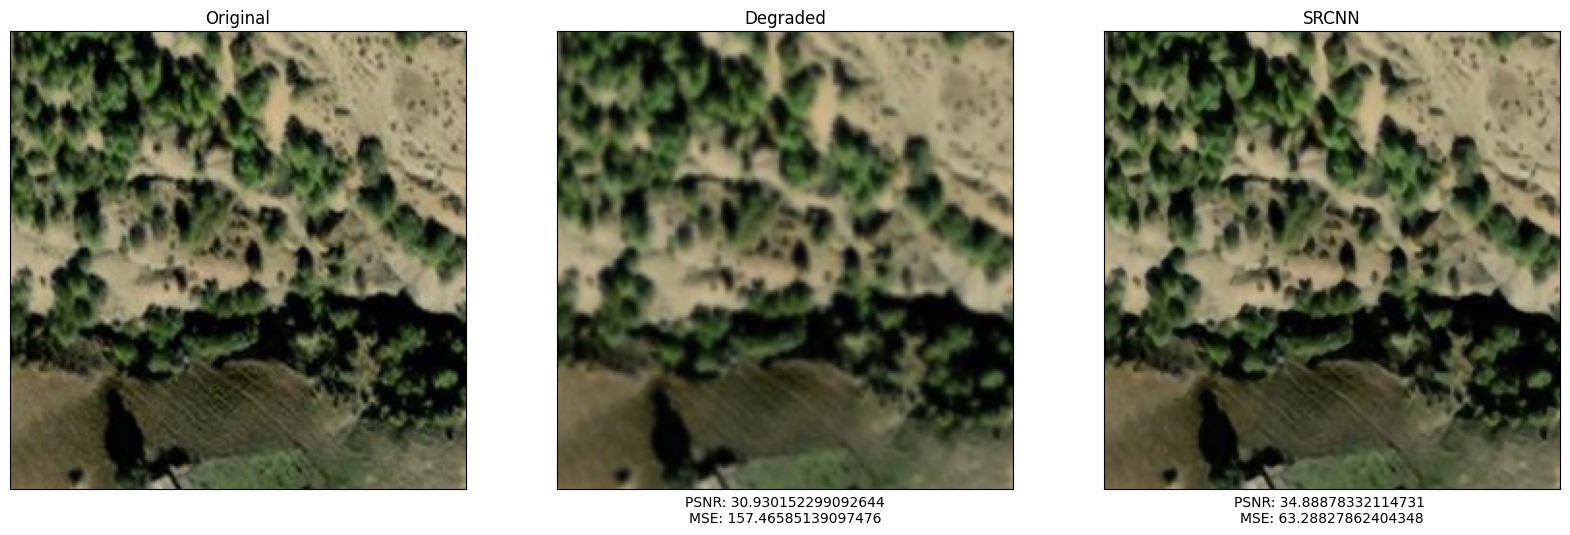

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
SRCNN output saved: output/butterfly.png.png


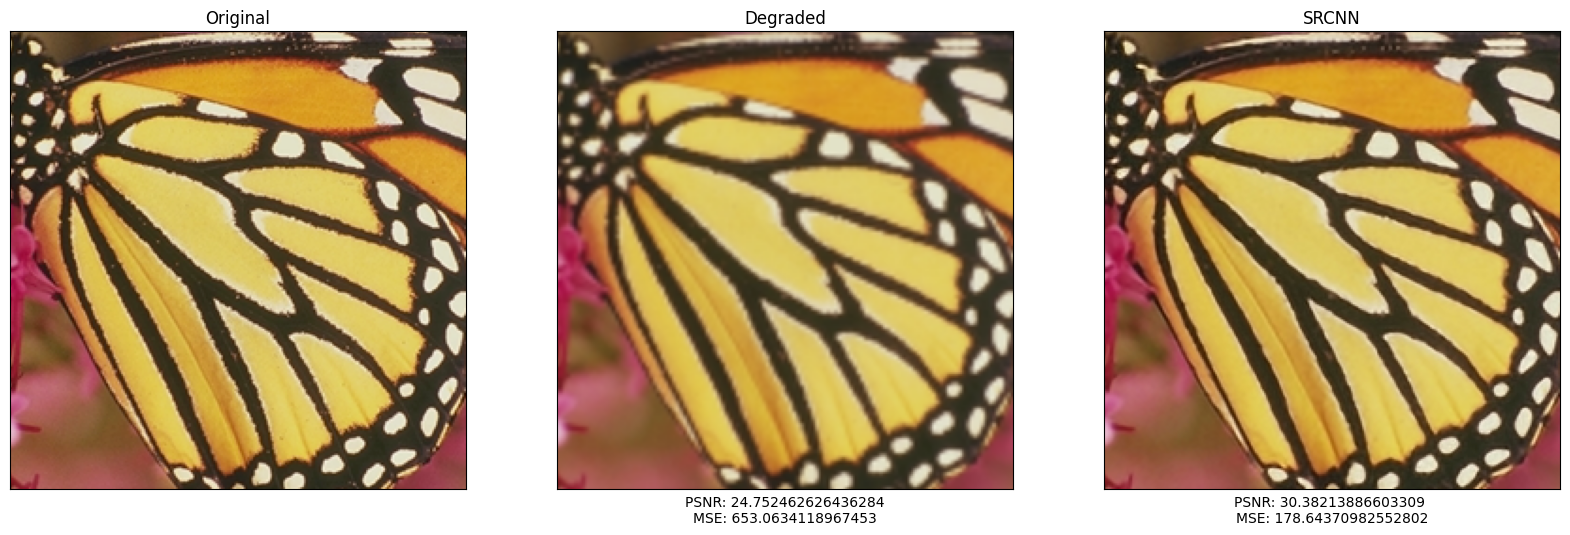

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
SRCNN output saved: output/iitpng.png.png


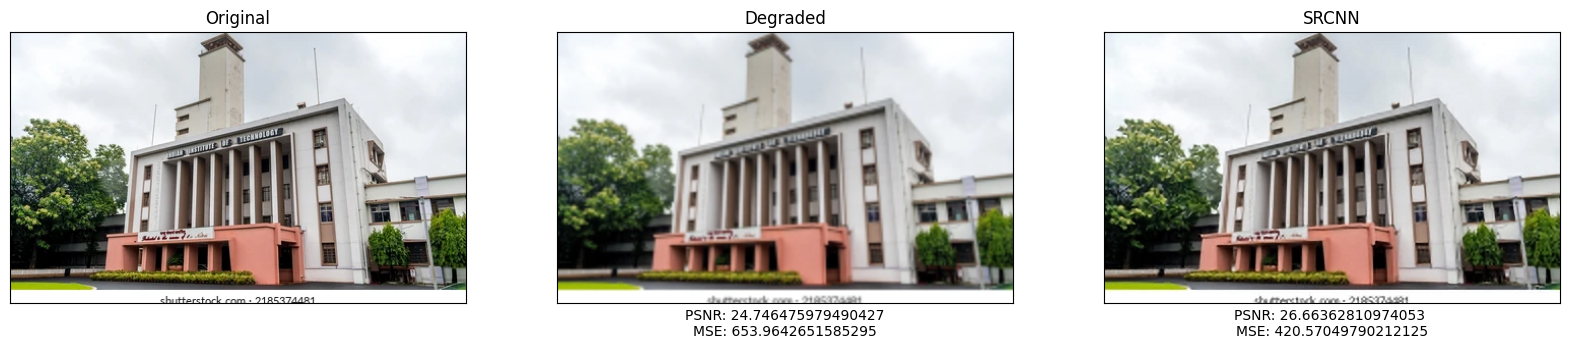

In [ ]:
# Performing Super Resolution using our SRCNN model on all images (degraded)

for file in os.listdir('images'):
    # perform super-resolution
    try:
      ref, degraded, output, scores = predict('images/{}'.format(file))
    except:
      continue

    save_path = 'output/{}.png'.format(file)
    cv2.imwrite(save_path, output)

    print(f"SRCNN output saved: {save_path}")
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {}'.format(scores[0][0], scores[0][1]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {}'.format(scores[1][0], scores[1][1]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    # print('Saving {}'.format(file))
    # fig.savefig('output/{}.png'.format(os.path.splitext(file)[0]))
    plt.show()  # ✅ Display the figure
    plt.close(fig)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


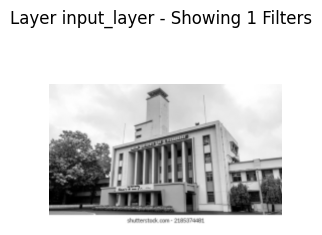

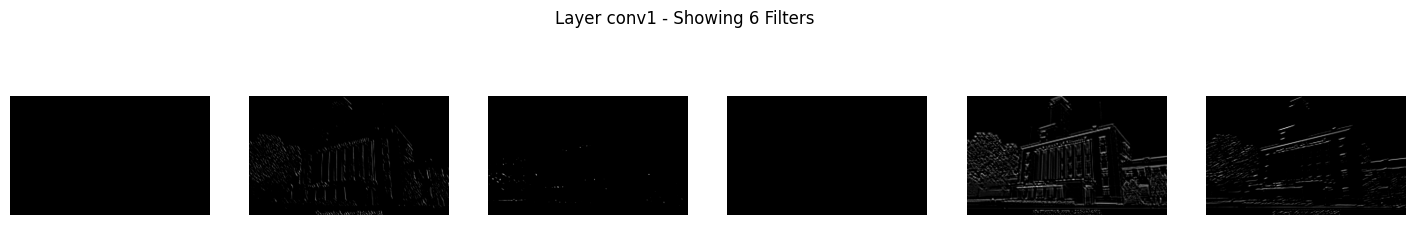

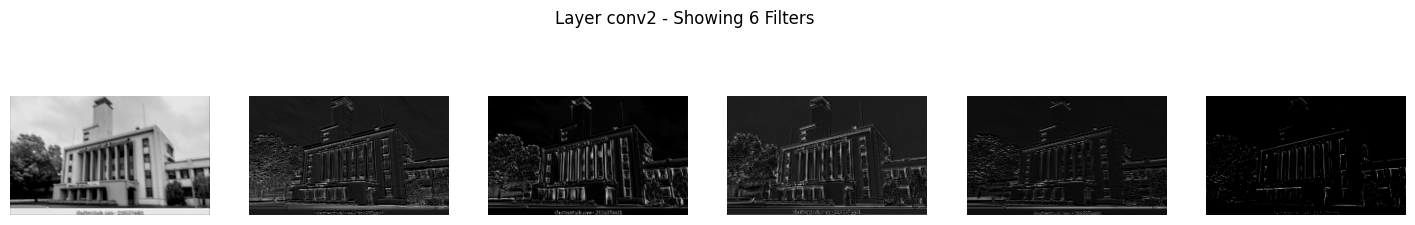

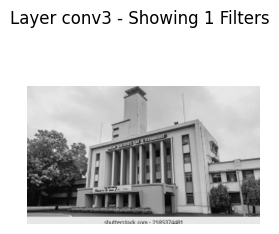


Layer conv1 weights shape:
(9, 9, 1, 128)
(128,)

Layer conv2 weights shape:
(3, 3, 128, 64)
(64,)

Layer conv3 weights shape:
(5, 5, 64, 1)
(1,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---- Build SRCNN with explicit Input ----
def build_srcnn():
    inp = Input(shape=(None, None, 1), name="input_layer")  # grayscale single-channel
    x = Conv2D(128, (9, 9), activation='relu', padding='valid',
               kernel_initializer='glorot_uniform', name='conv1')(inp)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_initializer='glorot_uniform', name='conv2')(x)
    out = Conv2D(1, (5, 5), activation='linear', padding='valid',
                 kernel_initializer='glorot_uniform', name='conv3')(x)

    model = Model(inputs=inp, outputs=out, name="SRCNN")
    adam = Adam(learning_rate=0.0003)
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# ---- Load model and weights ----
srcnn = build_srcnn()
srcnn.load_weights("3051crop_weight_200.h5")

# ---- Load a test image ----
img_path = "images/iitpng.png"  # your low-res image path
degraded = cv2.imread(img_path, cv2.IMREAD_COLOR)
degraded = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
Y = degraded[:, :, 0] / 255.0
Y = np.expand_dims(Y, axis=(0, -1))  # shape: (1, h, w, 1)

# ---- Create an activation model ----
layer_outputs = [layer.output for layer in srcnn.layers]
activation_model = Model(inputs=srcnn.input, outputs=layer_outputs)

# ---- Get activations for the image ----
activations = activation_model.predict(Y)

# ---- Plot 10 filters per layer ----
filters_to_show = 6  # number of filters to visualize

for i, activation in enumerate(activations):
    num_filters = activation.shape[-1]
    num_to_show = min(num_filters, filters_to_show)

    fig, axes = plt.subplots(1, num_to_show, figsize=(3*num_to_show, 3))
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    for j in range(num_to_show):
        axes[j].imshow(activation[0, :, :, j], cmap='gray')
        axes[j].axis('off')

    plt.suptitle(f"Layer {srcnn.layers[i].name} - Showing {num_to_show} Filters")
    plt.show()
    # ---- Show weights ----
for layer in srcnn.layers:
    weights = layer.get_weights()
    if weights:
        print(f"\nLayer {layer.name} weights shape:")
        for w in weights:
            print(np.array(w).shape)





Layer: conv1
Weight shape: (9, 9, 1, 128)
Bias shape: (128,)


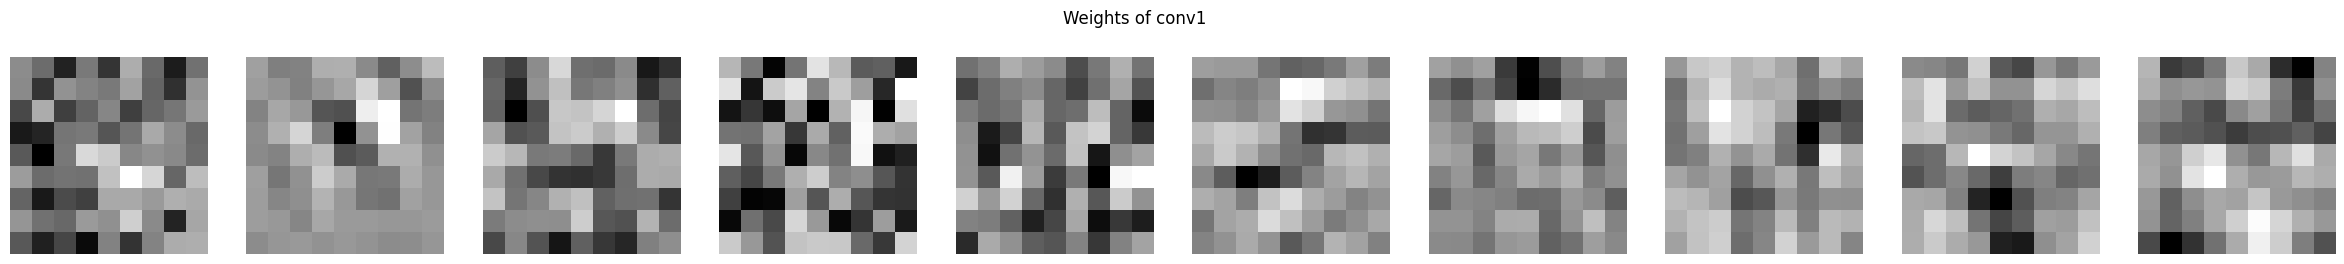


Layer: conv2
Weight shape: (3, 3, 128, 64)
Bias shape: (64,)


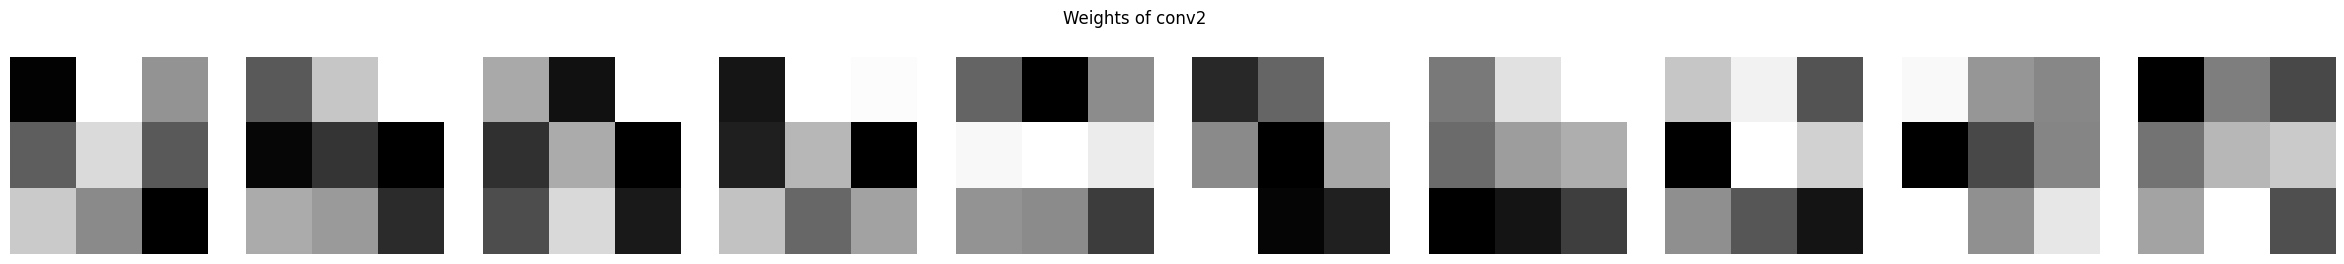


Layer: conv3
Weight shape: (5, 5, 64, 1)
Bias shape: (1,)


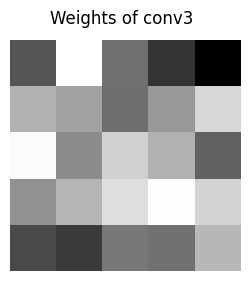

In [ ]:
# Loop through each Conv2D layer and display its weights
for layer in srcnn.layers:
    if 'conv' in layer.name.lower():
        weights, biases = layer.get_weights()
        print(f"\nLayer: {layer.name}")
        print(f"Weight shape: {weights.shape}")
        print(f"Bias shape: {biases.shape}")

        # Optionally print the raw weight values
        # print(weights)  # <-- Uncomment if you really want to see the numbers

        # Normalize and visualize first few filters
        num_filters_to_show = min(weights.shape[-1], 10)  # show up to 10 filters
        fig, axes = plt.subplots(1, num_filters_to_show, figsize=(3*num_filters_to_show, 3))
        if not isinstance(axes, np.ndarray):
            axes = [axes]

        for i in range(num_filters_to_show):
            # Take the first channel of the filter (Y channel)
            f = weights[:, :, 0, i]
            f_min, f_max = f.min(), f.max()
            f_normalized = (f - f_min) / (f_max - f_min) if f_max != f_min else f
            axes[i].imshow(f_normalized, cmap='gray')
            axes[i].axis('off')

        plt.suptitle(f"Weights of {layer.name}")
        plt.show()
